In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from typing import NoReturn, List
from sklearn.metrics import f1_score
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv('data_classification_for_task.csv', sep=',')
df.head()

,AGE,GENDER,FEATURE_1,FEATURE_2,FEATURE_3,FEATURE_4,FEATURE_5,FEATURE_6,FEATURE_7,FEATURE_8,FEATURE_9,FEATURE_10,FEATURE_11,TARGET
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [31]:
df.groupby('TARGET').count()

,AGE,GENDER,FEATURE_1,FEATURE_2,FEATURE_3,FEATURE_4,FEATURE_5,FEATURE_6,FEATURE_7,FEATURE_8,FEATURE_9,FEATURE_10,FEATURE_11
TARGET,,,,,,,,,,,,,
0,138,138,138,138,138,138,138,138,138,138,138,138,138
1,165,165,165,165,165,165,165,165,165,165,165,165,165


# Вспомогательные функции

In [3]:
def plt_normal_dist(X: pd.DataFrame) -> NoReturn:
    X_means = X.mean().reset_index().rename(columns={
        'index': 'indexs',
        0: 'mean'
    })

    plt.figure(figsize=(25, 5))

    for i, column in enumerate(X.columns, 1):
        if len(X_means[X_means.indexs == str(column)]) > 0:
            ax = plt.subplot(1, 5, i)
            ax.title.set_text(
                f'{column} - {X_means[X_means.indexs == str(column)]["mean"].values[0]}'
            )
            sns.histplot(X[column])
    return None

In [4]:
def identify_collinear(X: pd.DataFrame,
                       correlation_threshold: float) -> List[str]:
    '''
        Функция поиск корреляции признаков
        На вход принимает фрейм независимых переменных и значение для корреляции
        Возвращает список признаком с высокой корреляцией
    '''
    corr_matrix = X.corr()

    upper = corr_matrix.where(
        np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

    to_drop = [
        column for column in upper.columns
        if any(upper[column].abs() > correlation_threshold)
    ]

    record_collinear = pd.DataFrame(
        columns=['drop_feature', 'corr_feature', 'corr_value'])

    for column in to_drop:
        corr_features = list(
            upper.index[upper[column].abs() > correlation_threshold])
        corr_values = list(
            upper[column][upper[column].abs() > correlation_threshold])

        drop_features = [column for _ in range(len(corr_features))]

        temp_df = pd.DataFrame.from_dict({
            'drop_feature': drop_features,
            'corr_feature': corr_features,
            'corr_value': corr_values
        })

        record_collinear = record_collinear.append(temp_df, ignore_index=True)

    record_collinear = record_collinear
    return to_drop

# Подготовка данных

In [5]:
# Посмотрим на уникальные значения в каждом признаке
for i in df.columns:
    x = df[i].value_counts()
    print('column', i, 'values', len(x))

column AGE values 41
column GENDER values 2
column FEATURE_1 values 4
column FEATURE_2 values 49
column FEATURE_3 values 152
column FEATURE_4 values 2
column FEATURE_5 values 3
column FEATURE_6 values 91
column FEATURE_7 values 2
column FEATURE_8 values 40
column FEATURE_9 values 3
column FEATURE_10 values 5
column FEATURE_11 values 4
column TARGET values 2


In [6]:
categerical_features = ['GENDER', 'FEATURE_1', 'FEATURE_4', 'FEATURE_5', 'FEATURE_7', 'FEATURE_9', 'FEATURE_10', 'FEATURE_11']
numeric_features = ['AGE', 'FEATURE_2', 'FEATURE_3', 'FEATURE_6', 'FEATURE_8']

## Посмотрим на нормальное распределение фич

In [10]:
X = df.iloc[:, :-1]
y = df['TARGET']

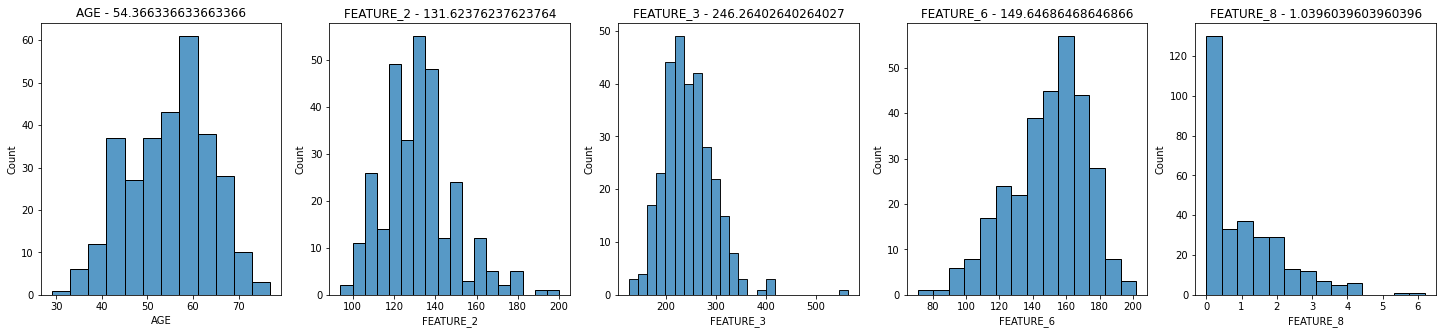

In [11]:
plt_normal_dist(X[numeric_features])

## Посмотрим есть ли дисбаланс в данных

Class 0:  138
Class 1:  165
Proportion: 1.2 : 1


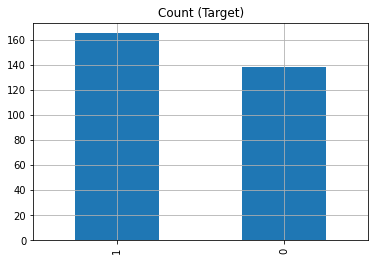

In [12]:
target_count = df.TARGET.value_counts()
print('Class 0: ', target_count[0])
print('Class 1: ', target_count[1])
print(f'Proportion: {round(target_count[1] / target_count[0], 2)} : 1')
target_count.plot(kind='bar', title='Count (Target)')
plt.grid()

## Посмотрим корреляционную матрицу и удалим признаки с сильной корреляцией(>0.7)

Признаки которые были удалены
[]


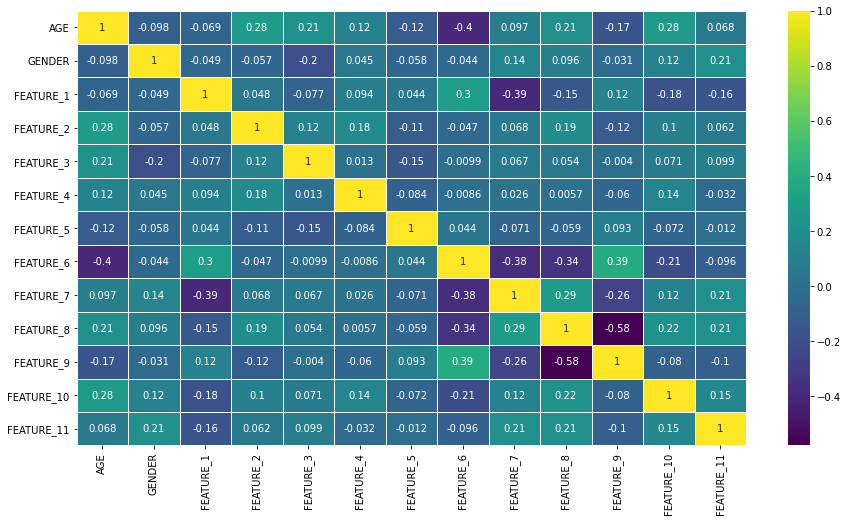

In [13]:
plt.figure(figsize=(15, 8))
ax = sns.heatmap(X.corr(), cmap='viridis', annot=True, linewidths=.5)
drop_col = identify_collinear(X, 0.7)
print(f'Признаки которые были удалены\n{drop_col}')
X.drop(drop_col, axis=1, inplace=True)

In [14]:
# Закодируем номинальные категориальный признак
X = pd.get_dummies(X, columns=categerical_features)

In [15]:
# Стандартизируем количественные данные
scaler = StandardScaler().fit_transform(X[numeric_features])
scaled_features_df = pd.DataFrame(scaler, index=X.index, columns=numeric_features)
X.drop(numeric_features, axis=1, inplace=True)
X = X.join(scaled_features_df)
X.head()

,GENDER_0,GENDER_1,FEATURE_1_0,FEATURE_1_1,FEATURE_1_2,FEATURE_1_3,FEATURE_4_0,FEATURE_4_1,FEATURE_5_0,FEATURE_5_1,...,FEATURE_10_4,FEATURE_11_0,FEATURE_11_1,FEATURE_11_2,FEATURE_11_3,AGE,FEATURE_2,FEATURE_3,FEATURE_6,FEATURE_8
0,0,1,0,0,0,1,0,1,1,0,...,0,0,1,0,0,0.952197,0.763956,-0.256334,0.015443,1.087338
1,0,1,0,0,1,0,1,0,0,1,...,0,0,0,1,0,-1.915313,-0.092738,0.072199,1.633471,2.122573
2,1,0,0,1,0,0,1,0,1,0,...,0,0,0,1,0,-1.474158,-0.092738,-0.816773,0.977514,0.310912
3,0,1,0,1,0,0,1,0,0,1,...,0,0,0,1,0,0.180175,-0.663867,-0.198357,1.239897,-0.206705
4,1,0,1,0,0,0,1,0,0,1,...,0,0,0,1,0,0.290464,-0.663867,2.082050,0.583939,-0.379244


In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [34]:
from sklearn.model_selection import GridSearchCV

param_grid = {'var_smoothing': np.logspace(0,-30, num=300)}

nb_classifier = GaussianNB()

grid_search = GridSearchCV(estimator=nb_classifier,
                           param_grid=param_grid,
                           cv=5,
#                            n_jobs=-1,
                           scoring='f1',
                           verbose=1)
grid_search.fit(X_train, y_train);

Fitting 5 folds for each of 300 candidates, totalling 1500 fits


In [35]:
print(grid_search.best_params_)

{'var_smoothing': 0.02481126055137769}


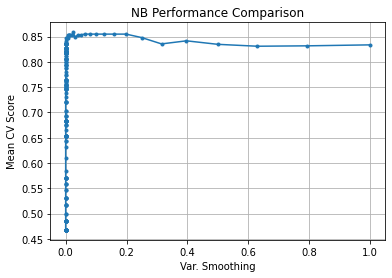

In [36]:
# Фрейм данных для хранения результатов поиск по сетке для визуализации
results_NB = pd.DataFrame(grid_search.cv_results_['params'])
results_NB['test_score'] = grid_search.cv_results_['mean_test_score']

# Построим график по var_smooting параметру
plt.plot(results_NB['var_smoothing'], results_NB['test_score'], marker = '.')    
plt.xlabel('Var. Smoothing')
plt.ylabel("Mean CV Score")
plt.title("NB Performance Comparison")
plt.grid()
plt.show()

In [37]:
# Оценим точно в метрике F1 - является средним гармоническим точности и полноты
#         2TP
#   ______________
#    2TP + FP + FN
#

nb_classifier = GaussianNB(var_smoothing=grid_search.best_params_['var_smoothing']).fit(X_train, y_train)
y_pred = nb_classifier.predict(X_test)
print(f'Точность по метрике F1:\t{round(f1_score(y_test, y_pred), 2) * 100} %')

Точность по метрике F1:	86.0 %
